Connecting Google Drive 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Required librari

In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Flatten 
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


Unzipping file

In [ ]:
!unzip "/content/drive/MyDrive/dataset/train_image.zip"

Streaming output truncated to the last 5000 lines.
  inflating: train_images/99f75320d.jpg  
  inflating: train_images/99f9d2375.jpg  
  inflating: train_images/99fd3c6f5.jpg  
  inflating: train_images/9a016fe15.jpg  
  inflating: train_images/9a064450d.jpg  
  inflating: train_images/9a08c2783.jpg  
  inflating: train_images/9a18e4457.jpg  
  inflating: train_images/9a1f7c238.jpg  
  inflating: train_images/9a2523ce9.jpg  
  inflating: train_images/9a3e774ff.jpg  
  inflating: train_images/9a5e9e77c.jpg  
  inflating: train_images/9a5f7a855.jpg  
  inflating: train_images/9a62177bb.jpg  
  inflating: train_images/9a67575cf.jpg  
  inflating: train_images/9a6ac5406.jpg  
  inflating: train_images/9a70057c0.jpg  
  inflating: train_images/9a72fd89e.jpg  
  inflating: train_images/9a75974ba.jpg  
  inflating: train_images/9a762b892.jpg  
  inflating: train_images/9a7b2f3af.jpg  
  inflating: train_images/9a7b427b4.jpg  
  inflating: train_images/9a81a8056.jpg  
  inflating: train_images

Loading CSV file 

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/dataset/train.csv')
print("Number of defective samples: ", train_df.shape[0])
train_df

Number of defective samples:  12568


,ImageId,ClassId
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1
...,...,...
12563,ffa8210a1.jpg,0
12564,ffaa05016.jpg,0
12565,ffd0223a7.jpg,0
12566,ffe93442c.jpg,0


In [ ]:
train_df['ClassId'] = train_df['ClassId'].astype(str)
train_df.head()


,ImageId,ClassId
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1


Checking data imbalance 

1    6666
0    5902
Name: ClassId, dtype: int64

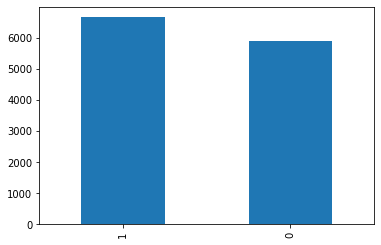

In [ ]:
train_df["ClassId"].value_counts().plot(kind = 'bar')
train_df["ClassId"].value_counts()

#Train Test Split

In [ ]:
def split(df):
  x_train,x_test,y_train,y_test=train_test_split(df.ImageId,df.ClassId,
                                               stratify=df.ClassId,
                                               random_state=7,
                                               test_size=0.3)
  
  train = pd.DataFrame(zip(x_train,y_train),columns=['ImageId','ClassId'])
  test = pd.DataFrame(zip(x_test,y_test),columns=['ImageId','ClassId'])
    
  return train,test

Image PreProcessing and data generation

In [ ]:
src_path_train = "/content/train_images/"

train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.30)

test_datagen = ImageDataGenerator(rescale=1 / 255.0)
train,test=split(train_df)

In [ ]:
batch_size = 32
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=src_path_train,
    x_col="ImageId",
    y_col="ClassId",
    target_size=(256, 256),
    batch_size=batch_size,
    color_mode='rgb',
    save_format='jpg',
    class_mode="binary",
    subset='training',
    shuffle=True,
    seed=42
)

Found 6158 validated image filenames belonging to 2 classes.


In [ ]:
valid_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=src_path_train,
    x_col="ImageId",
    y_col="ClassId",
    target_size=(256, 256),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode="binary",
    subset='validation',
    shuffle=True,
    seed=42
)

Found 2639 validated image filenames belonging to 2 classes.


Initialising Resnet50 Pretrained Model

In [ ]:
from tensorflow.keras.applications.resnet import ResNet50
import tensorflow as tf
pretrained_model = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3),
    pooling="avg",
    classes=2
)
for layer in pretrained_model.layers:
    layer.trainable = False

In [ ]:
def build_model():
    x = pretrained_model.output
    x = Flatten()(x)
    x = Dense(1024,activation = 'relu')(x)
    x = Dense(512,activation = 'relu')(x)
    x = Dropout(0.05)(x)
    out = Dense(1,activation = 'sigmoid')(x)
    model = tf.keras.Model(inputs = pretrained_model.input,outputs=out)
    return model

In [ ]:
model = build_model()

Compiling model

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 3e-6),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits = False),
                  metrics=['accuracy','AUC','Precision','Recall'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

mc = ModelCheckpoint(filepath="/content/drive/MyDrive/SteelDefectDetection/Steel_model_ver2/model_avg_pool.h5",monitor="loss",verbose=1,save_best_only=True)
es = EarlyStopping(monitor='loss', min_delta = 0.001, patience=3,verbose=1)

cb = [mc,es]

Training the Model 

In [ ]:
history = model.fit(train_generator,
              validation_data=valid_generator,
              epochs=5,
              callbacks=cb)

Epoch 1/5
193/193 [==============================] - ETA: 0s - loss: 0.6759 - accuracy: 0.5906 - auc: 0.5992 - precision: 0.5814 - recall: 0.8145
Epoch 1: loss improved from 0.67773 to 0.67586, saving model to /content/drive/MyDrive/SteelDefectDetection/Steel_model_ver2/model_avg_pool.h5
193/193 [==============================] - 219s 1s/step - loss: 0.6759 - accuracy: 0.5906 - auc: 0.5992 - precision: 0.5814 - recall: 0.8145 - val_loss: 0.6711 - val_accuracy: 0.6067 - val_auc: 0.6494 - val_precision: 0.5777 - val_recall: 0.9614
Epoch 2/5
193/193 [==============================] - ETA: 0s - loss: 0.6721 - accuracy: 0.6039 - auc: 0.6154 - precision: 0.5870 - recall: 0.8539
Epoch 2: loss improved from 0.67586 to 0.67208, saving model to /content/drive/MyDrive/SteelDefectDetection/Steel_model_ver2/model_avg_pool.h5
193/193 [==============================] - 204s 1s/step - loss: 0.6721 - accuracy: 0.6039 - auc: 0.6154 - precision: 0.5870 - recall: 0.8539 - val_loss: 0.6698 - val_accuracy: 

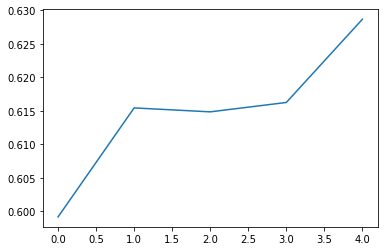

In [ ]:
plt.plot(history.history['auc'])

Plot of validation and Loss Curve

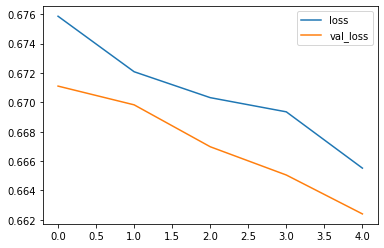

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])

Testing the test_set

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/SteelDefectDetection/Steel_model_ver2/model.h5")

testing = test_datagen.flow_from_dataframe(test,
    directory='/content/train_images',
    x_col='ImageId',
    y_col='ClassId',
    target_size=(256,256),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    classes=('0','1'),
    shuffle=False,
    save_format='jpg',
    interpolation='nearest',
    validate_filenames=True,
)

predictions = model.predict(testing,32)

Found 3771 validated image filenames belonging to 2 classes.
118/118 [==============================] - 1137s 10s/step


Mapping the predictions with labels 

In [ ]:
count_undef=0
count_def=0
prediction=[]
for i in predictions:
  if i > [0.45]:
    prediction.append('undefective')
    count_undef+=1
  else:
    prediction.append('defective')
    count_def+=1

In [ ]:
print('Number of defective images ',count_def)
print('Number of undefective images ',count_undef)
print(prediction)

Number of defective images  2533
Number of undefective images  1238
['undefective', 'defective', 'defective', 'defective', 'undefective', 'undefective', 'defective', 'defective', 'undefective', 'defective', 'defective', 'defective', 'defective', 'defective', 'defective', 'defective', 'undefective', 'defective', 'defective', 'defective', 'defective', 'undefective', 'undefective', 'undefective', 'defective', 'defective', 'undefective', 'undefective', 'defective', 'defective', 'undefective', 'defective', 'undefective', 'defective', 'defective', 'defective', 'undefective', 'defective', 'defective', 'defective', 'undefective', 'undefective', 'undefective', 'defective', 'undefective', 'defective', 'defective', 'defective', 'undefective', 'defective', 'defective', 'undefective', 'defective', 'defective', 'undefective', 'defective', 'defective', 'defective', 'defective', 'undefective', 'defective', 'defective', 'defective', 'undefective', 'undefective', 'defective', 'defective', 'undefective',